## Install Necessary Dependencies

In [9]:
!pip install yfinance numpy pandas scipy matplotlib

## Load Spot and Option Data from Yahoo Finance

In [81]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# get SPY spot price
spy = yf.Ticker("SPY")
spot_data = spy.history(period="6mo", interval="1d")
spot_data = spot_data[['Close']]
spot_data.rename(columns={'Close': 'Spot'}, inplace=True)

# example expiry for options
expiry = spy.options[2]  
opt_chain = spy.option_chain(expiry)
calls = opt_chain.calls
puts = opt_chain.puts

## Black-Scholes Gamma Function

In [82]:
def black_scholes_gamma(S, K, T, r, sigma, option_type='call'):
    # avoid invalid or zero values
    if S <= 0 or K <= 0 or sigma <= 0 or T <= 0:
        return np.nan
    try:
        d1 = (np.log(S / K) + (r + 0.5 * sigma**2)*T) / (sigma * np.sqrt(T))
        gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
        return gamma
    except:
        return np.nan

## Apply Gamma Calculation to Option Chain

In [109]:

r = 0.05  # risk-free rate assumption

def calculate_gamma_for_chain(df, spot_price, r, option_type='call'):
    today = pd.Timestamp.today().tz_localize(None)
    T = (pd.to_datetime(expiry) - today).days / 365
    if T <= 0:
        raise ValueError("Option expiry is today or in the past.")

    df = df.copy()
    # drop rows with missing or zero implied vol
    df = df[(df['impliedVolatility'] > 0) & df['strike'] > 0]
    
    df['Gamma'] = df.apply(lambda row: black_scholes_gamma(
        S=spot_price,
        K=row['strike'],
        T=T,
        r=r,
        sigma=row['impliedVolatility'],
        option_type=option_type
    ), axis=1)
    return df

##  Approximate Spot Sensitivity of Gamma

In [110]:
def gamma_spot_sensitivity(K, T, r, sigma, spot_price, epsilon=1.0):
    gamma_up = black_scholes_gamma(S=spot_price + epsilon, K=K, T=T, r=r, sigma=sigma)
    gamma_down = black_scholes_gamma(S=spot_price - epsilon, K=K, T=T, r=r, sigma=sigma)
    return (gamma_up - gamma_down) / (2 * epsilon)

## Estimate ∂Γ/∂S for each strike

In [119]:
def add_spot_sensitivity(df, spot_price, r):
    today = pd.Timestamp.today().tz_localize(None)
    T = (pd.to_datetime(expiry) - today).days / 365
    if T <= 0:
        raise ValueError("Option expiry is today or in the past.")

    df = df.copy()
    df = df[(df['impliedVolatility'] > 0) & (df['strike'] > 0)]

    df['dGamma_dS'] = df.apply(lambda row: gamma_spot_sensitivity(
        K=row['strike'],
        T=T,
        r=r,
        sigma=row['impliedVolatility'],
        spot_price=spot_price
    ), axis=1)
    if df['dGamma_dS'].notna().sum() > 0:
        df['dGamma_dS_smooth'] = df['dGamma_dS'].rolling(window=3, center=True).mean()
    else:
        print("Warning: dGamma_dS is all NaNs, skipping smoothing.")
    return df

## Plotting Spot Sensitivity of Gamma

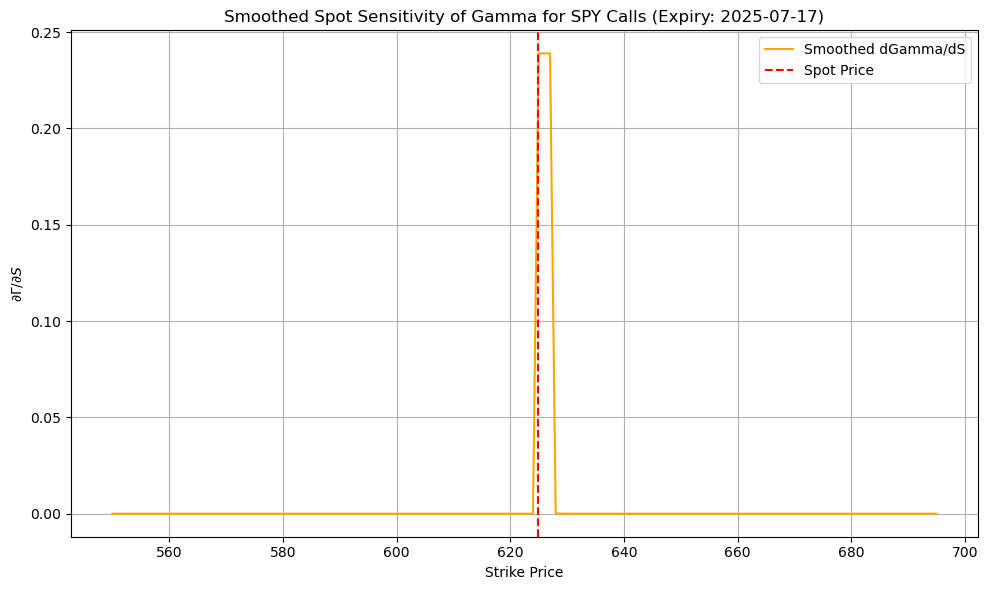

In [121]:
gamma_calls = add_spot_sensitivity(calls, spot_price=spot_data.iloc[-1]['Spot'], r=r)

plt.figure(figsize=(10,6))
plt.plot(gamma_calls['strike'], gamma_calls['dGamma_dS_smooth'], color='orange', label='Smoothed dGamma/dS')
plt.axvline(x=spot_data.iloc[-1]['Spot'], color='red', linestyle='--', label='Spot Price')
plt.xlabel('Strike Price')
plt.ylabel(r'$\partial \Gamma / \partial S$')
plt.title(f'Smoothed Spot Sensitivity of Gamma for SPY Calls (Expiry: {expiry})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Add Simulated Spot Move and ΔΓ to DataFrame

In [124]:
# Simulate a 2-point move in spot price
delta_S = 2.0
gamma_calls['DeltaGamma_due_to_SpotMove'] = gamma_calls['dGamma_dS'] * delta_S
gamma_calls['DeltaGamma_smooth'] = gamma_calls['DeltaGamma_due_to_SpotMove'].rolling(window=3, center=True).mean()

## Plot the Predicted Gamma Change

<>:7: SyntaxWarning: invalid escape sequence '\D'
<>:7: SyntaxWarning: invalid escape sequence '\D'
C:\Users\Mohan\AppData\Local\Temp\ipykernel_7340\3928667897.py:7: SyntaxWarning: invalid escape sequence '\D'
  plt.title(f'Raw vs Smoothed $\Delta \Gamma$ from $\\Delta S$ = {delta_S} (SPY Calls)')


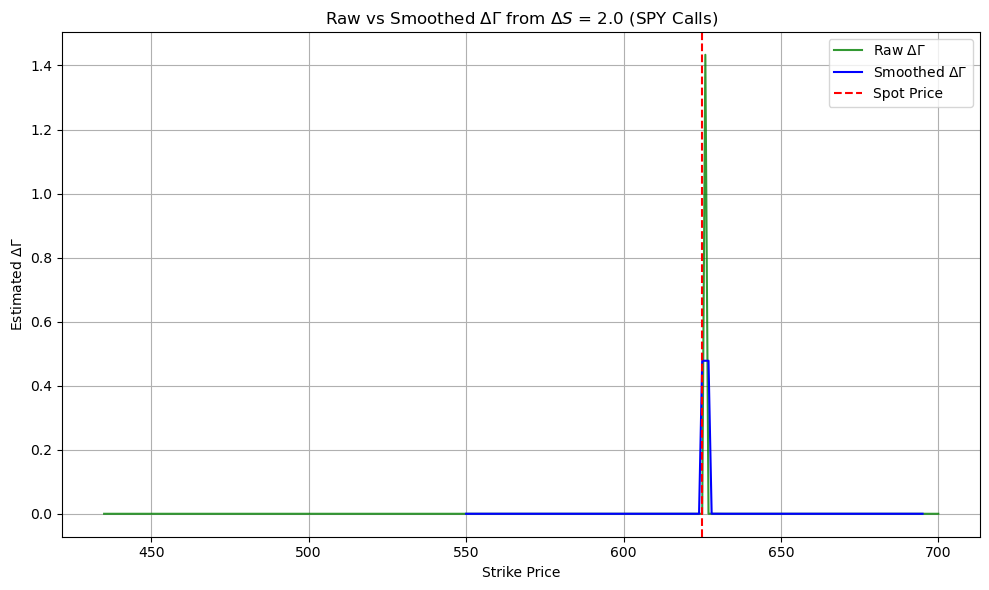

In [140]:
plt.figure(figsize=(10,6))
plt.plot(gamma_calls['strike'], gamma_calls['DeltaGamma_due_to_SpotMove'], alpha=0.8, label=r'Raw $\Delta \Gamma$', color='green')
plt.plot(gamma_calls['strike'], gamma_calls['DeltaGamma_smooth'], label=r'Smoothed $\Delta \Gamma$', color='blue')
plt.axvline(x=spot_data.iloc[-1]['Spot'], color='red', linestyle='--', label='Spot Price')
plt.xlabel('Strike Price')
plt.ylabel(r'Estimated $\Delta \Gamma$')
plt.title(f'Raw vs Smoothed $\Delta \Gamma$ from $\\Delta S$ = {delta_S} (SPY Calls)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Time-Series Tracking of Gamma and Spot

# Define Daily Snapshot Function

In [141]:
def get_gamma_snapshot(expiry, target_date, r=0.05):
    # Get spot for that historical date
    hist = spy.history(start=target_date, end=target_date + timedelta(days=1))
    if hist.empty:
        return None
    spot = hist['Close'].iloc[0]

    chain = spy.option_chain(expiry)
    calls = chain.calls.copy()

    # Use nearest strike
    atm_strike = calls.iloc[(calls['strike'] - spot).abs().argsort()[:1]]['strike'].values[0]
    call = calls[calls['strike'] == atm_strike].copy()

    T = (pd.to_datetime(expiry) - target_date).days / 365
    sigma = call['impliedVolatility'].values[0]

    gamma = black_scholes_gamma(S=spot, K=atm_strike, T=T, r=r, sigma=sigma)
    position_size = 100 * 100
    gamma_exposure = gamma * (spot ** 2) * position_size

    return {
        'Date': target_date,
        'Spot': spot,
        'Strike': atm_strike,
        'IV': sigma,
        'Gamma': gamma,
        'GammaExposure': gamma_exposure
    }

# Track Over Time (Simulated)

In [142]:
def simulate_gamma_timeseries(expiry, days=10):
    today = pd.Timestamp.today().normalize()
    dates = [today - timedelta(days=i) for i in range(days)]
    data = []

    for date in reversed(dates):
        try:
            snapshot = get_gamma_snapshot(expiry, date)
            if snapshot:
                data.append(snapshot)
        except Exception as e:
            print(f"Skipped {date.date()}: {e}")
            continue

    return pd.DataFrame(data)

# Plot Spot vs Gamma

$SPY: possibly delisted; no price data found  (1d 2025-07-06 00:00:00 -> 2025-07-07 00:00:00)
$SPY: possibly delisted; no price data found  (1d 2025-07-12 00:00:00 -> 2025-07-13 00:00:00)
$SPY: possibly delisted; no price data found  (1d 2025-07-13 00:00:00 -> 2025-07-14 00:00:00)


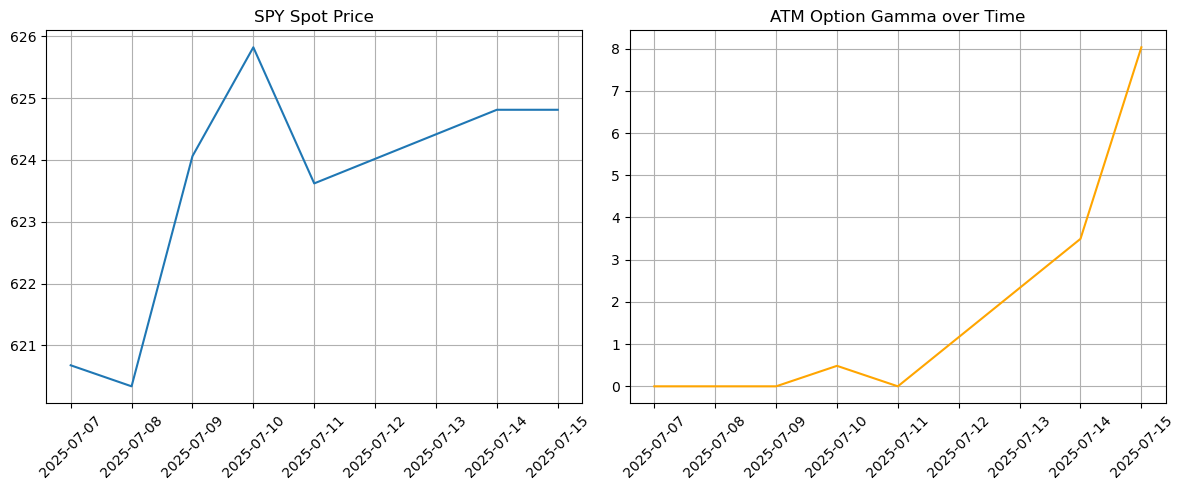

In [143]:
df = simulate_gamma_timeseries(expiry, days=10)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(df['Date'], df['Spot'], label='Spot Price')
plt.title('SPY Spot Price')
plt.xticks(rotation=45)
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(df['Date'], df['Gamma'], label='ATM Gamma', color='orange')
plt.title('ATM Option Gamma over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Gamma Exposure Over Time

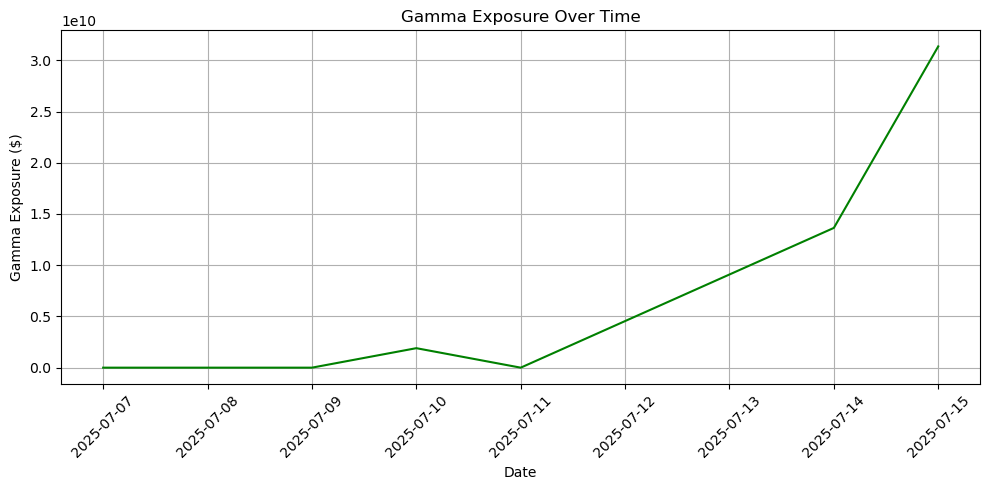

In [144]:
plt.figure(figsize=(10,5))
plt.plot(df['Date'], df['GammaExposure'], label='Gamma Exposure ($)', color='green')
plt.title('Gamma Exposure Over Time')
plt.xlabel('Date')
plt.ylabel('Gamma Exposure ($)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## actual vs predicted Gamma

# Compute ΔS and ΔΓactual

In [145]:
df['Delta_S'] = df['Spot'].diff()
df['Actual_Delta_Gamma'] = df['Gamma'].diff()

# Estimate ∂Γ/∂S

In [146]:
df['dGamma_dS'] = df['Actual_Delta_Gamma'] / df['Delta_S']

# Compute Predicted ΔGamma

In [147]:
df['Predicted_Delta_Gamma'] = df['dGamma_dS'].shift(1) * df['Delta_S']

# Compare Visually and Numerically

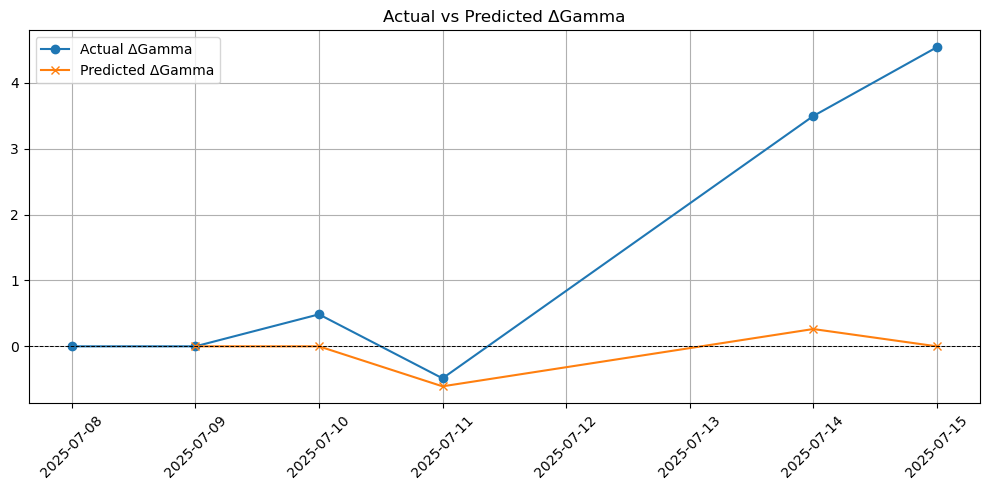

In [148]:
plt.figure(figsize=(10,5))
plt.plot(df['Date'], df['Actual_Delta_Gamma'], label='Actual ΔGamma', marker='o')
plt.plot(df['Date'], df['Predicted_Delta_Gamma'], label='Predicted ΔGamma', marker='x')
plt.axhline(0, color='black', linestyle='--', linewidth=0.7)
plt.legend()
plt.title('Actual vs Predicted ΔGamma')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()